<h1><center><font size='25'>Predicción del precio de Bitcoin con Python, cuando el pasado no se repite</font></center></h1>

<center><b>Javier Escobar Ortiz</b></center>

<center><i>Febrero, 2022</i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Skforecast: forecasting series temporales con Python y Scikit Learn](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html)
+ [Predicción (forecasting) de la demanda eléctrica con Python](https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html)
+ [Predicción (forecasting) de visitas a página web con machine learning](https://www.cienciadedatos.net/documentos/py37-forecasting-visitas-web-machine-learning.html)
+ [Forecasting series temporales con gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-series-temporales-con-skforecast-xgboost-lightgbm-catboost.html)

## Introducción
<br>

Una serie temporal (*time series*) es una sucesión de datos ordenados cronológicamente y espaciados a intervalos iguales o desiguales. El proceso de *forecasting* consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado o empleando otras variables adicionales.

En términos generales, al crear un modelo de forecaster se utilizan datos históricos con el objetivo de obtener una representación matemática capaz de predecir futuros valores. Esta idea se fundamenta sobre una asunción muy importante, **el comportamiento futuro de un fenómeno se puede explicar a partir de su comportamiento pasado**. Sin embargo, esto raramente ocurre en la relaidad, o al menos, no en su totalidad. Para profundizar en esto, vease la siguiente definición:

<p style="text-align: center;"> $Forecast = patrones + varianza\;no\;explicada$ </p>

El primer término de la ecuación hace referencia a todo aquello que tiene un carácter repetitivo a lo largo del tiempo (tendencia, estacionalidad, factores cíclicos...). El segundo término, representa todo aquello que influye en la variable respuesta pero que no está recogido (explicado) por el pasado de la serie temporal.

Cuanto mayor importancia tenga el primer término respecto al segundo, mayor será la probabilidad de exito al tratar de crear modelos de *forecasting* de tipo autoregresivo. A medida que el segundo término adquiere peso, se hace necesario incorporar al modelo variables adicionales (si es que existen) que ayuden a explicar el comportamiento observado.

Realizar un buen estudio del fenómeno modelado y saber reconocer en qué medida 
su comportamiento puede explicarse gracias a su pasado, puede ahorrar muchos esfuerzos inecesarios.

En este documento se muestra un ejemplo de cómo identificar situaciones en las que el proceso de *forecasting autorregresivo* no consigue resultados útiles. Como ejemplo, se intenta predecir el precio de cierre diario de Bitcoin utlizando métodos de *machine learning*. Se hace uso de [**Skforecast v0.4.2**](https://joaquinamatrodrigo.github.io/skforecast/0.4.2/index.html), una sencilla librería de Python que permite, entre otras cosas, adaptar cualquier regresor de **Scikit-learn** a problemas de *forecasting*.
<br>

## Caso de uso
<br>

<img src='./images/btc.png' style='width: 100px; padding-right: 20px; padding-left: 15px; padding-top: 5px' align='left'>

[Bitcoin](https://es.wikipedia.org/wiki/Bitcoin) (₿) es una criptomoneda descentralizada que puede enviarse de un usuario a otro mediante la red bitcoin peer-to-peer sin necesidad de intermediarios. Las transacciones son verificadas y registradas en un libro de contabilidad público distribuido llamado *blockchain*. Los Bitcoins se crean como recompensa por un proceso conocido como [minería](https://es.wikipedia.org/wiki/Miner%C3%ADa_de_bitcoin) y pueden intercambiarse por otras monedas, productos y servicios. 

Aunque puedan existir diversas opiniones sobre Bitcoin, bien como un activo especulativo de alto riesgo o, por otro lado, como una reserva de valor, es innegable que este se ha convertido en uno de los activos financieros más valiosos a nivel mundial. La página web [Infinite Market Cap](https://8marketcap.com/) muestra un listado de todos los activos financieros ordenados según su capitalización de mercado y, Bitcoin, a fecha de este artículo, se encuentra en el top 10 cerca de empresas mundialmente conocidas como Tesla o, incluso, de la plata, un valor refugio globalmente aceptado. El creciente interés en Bitcoin, y el mundo de las criptomonedas en general, por parte de los inversores lo convierte en un fenómeno interesante de modelar.  

Se pretende generar un modelo de *forecasting* capaz de predecir el precio de Bitcoin. Se dispone de una serie temporal con los precios de apertura (*Open*), cierre (*Close*), máximo (*High*) y mínimo (*Low*) de Bitcoin en dólares estadounidenses (USD) desde el 2013-04-28 al 2022-01-01. 
<br><br>

## Librerias

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import datetime
from cryptocmd import CmcScraper
from tqdm import tqdm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import stats
plt.style.use('ggplot')

# Colores Bitcoin
# ==============================================================================
palette_btc = {'naranja': '#f7931a',
               'blanco' : '#ffffff',
               'gris' : '#4d4d4d',
               'azul' : '#0d579b',
               'verde' : '#329239'
              }

# Modelado y Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

## Datos
<br>

La descarga de datos se realiza mediante [cryptocmd](https://openbase.com/python/cryptocmd). Esta librería es útil para descargar datos históricos de criptomonedas de la página [Coinmarketcap](https://coinmarketcap.com/). La información de cada columna es:

+ `Data`: fecha del registro.

+ `Open`: precio de apertura, precio al que cotiza un activo, en este caso el Bitcoin, en el comienzo del día. Expresado en dólares estadounidenses (USD).

+ `High`: precio máximo del día, precio más alto alcanzado por el Bitcoin en ese día, (USD).

+ `Low`: precio mínimo del día, precio más bajo alcanzado por el Bitcoin en ese día, (USD).

+ `Close`: precio de cierre, precio al que cotiza el Bitcoin a la finalización del día, (USD).

+ `Volume`: volumen, suma de las operaciones reales realizadas durante el día, (USD).

+ `Market Cap`: capitalización de mercado, es el valor total de todas las acciones de una empresa o, en el caso de Bitcoin u otra criptomoneda, de todas las monedas que hay en circulación, (USD).

*Nota: el mercado de las criptomonedas es un mercado ininterrumpido, opera las 24 horas del día, los 7 días de la semana. De todas maneras, no es extrictamente necesario que el precio close coincida exactamente con el precio open del día siguiente debido a las fluctuaciones que pueda sufrir el valor de Bitcoin, o cualquier criptomoneda, durante el último segundo del día.*

In [2]:
# Descarga de datos
# ==============================================================================

# Se inicializa el Scraper, se incluye simbolo, inicio y fin de la descarga
scraper = CmcScraper('BTC', '28-04-2013', '01-01-2022')

# Transformar datos recogidos en un dataframe
data = scraper.get_dataframe()
data.sort_values(by='Date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data)
pd.reset_option('display.max_columns')

,Date,Open,High,Low,Close,Volume,Market Cap
3170,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3169,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3168,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3167,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3166,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2021-12-28,50679.859377,50679.859377,47414.209925,47588.854777,3.343038e+10,9.000762e+11
3,2021-12-29,47623.870463,48119.740950,46201.494371,46444.710491,3.004923e+10,8.784788e+11
2,2021-12-30,46490.606049,47879.965500,46060.313166,47178.125843,2.668649e+10,8.923863e+11
1,2021-12-31,47169.372859,48472.527490,45819.954553,46306.446123,3.697417e+10,8.759394e+11


In [3]:
# Preparación del dato
# ==============================================================================
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

Al establecer una frecuencia con el método `asfreq()`, **Pandas** completa los huecos que puedan existir en la serie temporal con el valor de `Null` con el fin de asegurar la frecuencia indicada, [ejemplo](https://github.com/JoaquinAmatRodrigo/skforecast/issues/81). Por ello, se debe comprobar si han aparecido missing values tras esta transformación.

In [4]:
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


## Halving del Bitcoin como varible exógena
<br>

El Halving es un evento programado y forma parte del diseño y funcionamiento de algunas criptomonedas. Los mineros se dedican a validar los bloques de transacciones de la red, en este caso Bitcoin, y, cada vez que lo logran, reciben como recompensa una cantidad de esa moneda digital. Esta cantidad es fija pero sólo durante un tiempo.

En la *blockchain* de Bitcoin, cada vez que se añaden 210.000 bloques ocurre el cambio de recompensa. Este hecho, denominado como *halving*, se produce aproximadamente cada 4 años y reduce a la mitad las monedas que reciben los mineros como recompensa.

En la historia de Bitcoin han existido 3 *halvings*. Cuando se lanzó la minería de Bitcoin, los mineros recibían 50 BTC al extraer con éxito un bloque. En 2012 esta recompensa se redujo a 25 BTC, en 2016 bajó a 12,5 BTC, y en 2020 a 6,25 BTC, después del tercer halving. Por lo general, cada halving ha tenido un impacto en el precio aunque no necesariamente ha sido en el corto plazo.

Se pretende utilizar los días restantes para el próximo *halving* y sus recompensas de minado como **variables exógenas** para predecir el precio del Bitcoin. Se calcula que el próximo *halving* ocurrirá aproximadamente en 2024 aunque se desconoce su fecha exacta. Para estimarla, se toman los bloques restantes a fecha de 2022-01-14 de la página web [Coinmarketcap](https://coinmarketcap.com/es/halving/bitcoin/), 121.400, y se utiliza el promedio de los bloques de la red Bitcoin minados por día, 144 ([tiempo de bloque promedio](https://es.wikipedia.org/wiki/Bitcoin) $\approx$ 10 minutos).

*Nota: Al introducir una predicción como variable exógena en el modelo de forecasting se está introduciendo, dado que se trata de predicciones, su error en el modelo.*
<br>

In [49]:
# Dict con la info de los halvings del Bitcoin
# ==============================================================================
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [50]:
# Cálculo siguiente halving
# Se toma como base de partida los bloques restantes según la web 
# coinmarketcap.com para el próximo halving a fecha de 2022-01-14
# ==============================================================================
bloques_restantes = 121400
bloques_por_dia = 144

dias = bloques_restantes / bloques_por_dia

next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving

print(f'EL próximo halving ocurrirá aproximadamente el: {next_halving}')

EL próximo halving ocurrirá aproximadamente el: 2024-05-06


In [51]:
# Incluir recompensas y cuenta regresiva para próximo halving en el dataset
# ==============================================================================
data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):
     
    # Fecha inicial y final de cada halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')
    else:
        start_date = btc_halving['date'][i]
        
    end_date = btc_halving['date'][i+1]
    mask = (data.index >= start_date) & (data.index < end_date)
        
    # Rellenar columna 'reward' con las recompensas de minería
    data.loc[mask, 'reward'] = btc_halving['reward'][i]
    
    # Rellenar columna 'countdown_halving' con los días restantes
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    
    data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

In [52]:
# Comprobar que se han creado los datos correctamente
# ==============================================================================
print('Segundo halving:', btc_halving['date'][2])
display(data.loc['2016-07-08':'2016-07-09'])
print('')
print('Tercer halving:', btc_halving['date'][3])
display(data.loc['2020-05-10':'2020-05-11'])
print('')
print('Próximo halving:', btc_halving['date'][4])
data.tail(2)

Segundo halving: 2016-07-09


,open,close,high,low,reward,countdown_halving,dia_mes
date,,,,,,,
2016-07-08,640.687988,666.523010,666.706970,636.466980,25.0,0.0,8
2016-07-09,666.383972,650.960022,666.383972,633.398987,12.5,1401.0,9



Tercer halving: 2020-05-11


,open,close,high,low,reward,countdown_halving,dia_mes
date,,,,,,,
2020-05-10,9591.169231,8756.431142,9595.580629,8395.107451,12.50,0.0,10
2020-05-11,8755.535639,8601.796202,9033.471176,8374.322975,6.25,1455.0,11



Próximo halving: 2024-05-06


,open,close,high,low,reward,countdown_halving,dia_mes
date,,,,,,,
2021-12-31,47169.372859,46306.446123,48472.527490,45819.954553,6.25,856.0,31
2022-01-01,46311.744663,47686.811509,47827.310995,46288.486095,6.25,855.0,1


## Exploración Gráfica
<br>

Cuando se quiere generar un modelo de *forecasting*, es importante representar los valores de la serie temporal. Esto permite identificar patrones tales como tendencias y estacionalidad.

### Gráfico de velas

Un [gráfico de velas japonesas](https://es.wikipedia.org/wiki/Gr%C3%A1fico_de_velas) es un tipo de gráfico muy utilizado en el mundo del análisis técnico. El cuerpo de la vela indica la variación entre el precio de apertura y cierre, para un periodo determinado, mientras que los pelos o sombras indican los valores mínimo y máximo alcanzados durante ese periodo.

<center><img src="./images/vela_japonesa.png" style='width: 200px; padding-bottom: 5px' align='center'></center>

<center><font size='2.5'> <i>Construcción de una vela japonesa. La primera barra es un gráfico de barra, el segundo una vela japonesa al alza y la última una vela japonesa a la baja. Fuente <a href="https://es.wikipedia.org/wiki/Gr%C3%A1fico_de_velas#/media/Archivo:VelasBasico.png">Wikipedia</a>.</i></font></center>

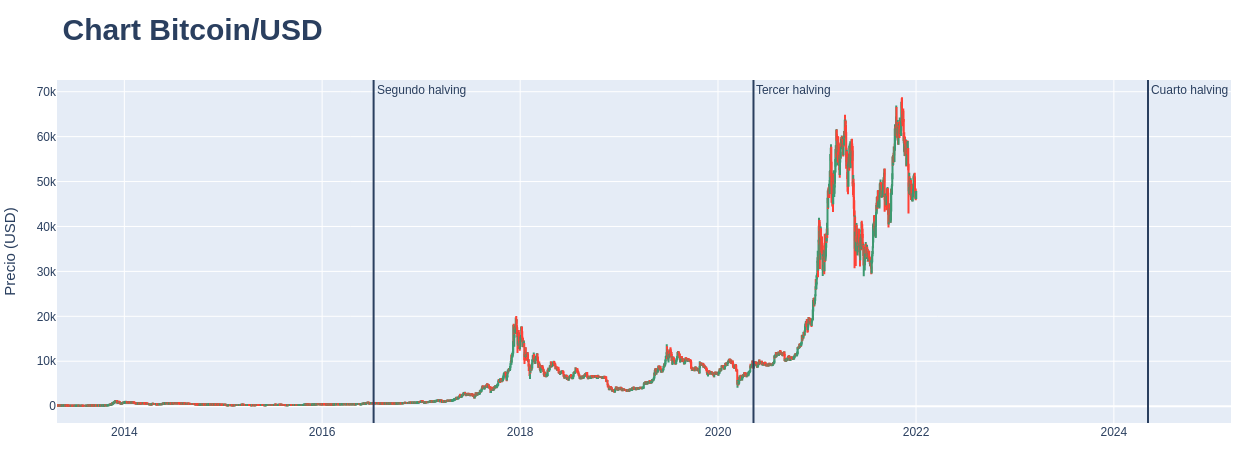

In [53]:
# Gráfico de velas japonesas
# ==============================================================================
candlestick = go.Candlestick(
                            x = data.index,
                            open = data.open,
                            close = data.close,
                            low = data.low,
                            high = data.high,
                            )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Chart Bitcoin/USD</b>', font=dict(size=30)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Segundo halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Tercer halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Cuarto halving')
                  ],
    xaxis_rangeslider_visible = False,
)

fig.show()

### Distribución de los datos

Se muestra la distribución del precio de cierre de Bitcoin, variable `close`:

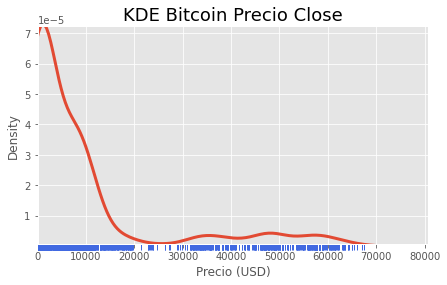

In [54]:
# Distribución KDE del precio de cierre del Bitcoin
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin Precio Close', fontsize=18)
p.set_xlabel('Precio (USD)');

En los datos de estudio se ve una distribución mayoritaria con el precio localizado por debajo de los 20.000 (USD), esta etapa corresponde al periodo entre el año 2013 y septiembre de 2020. En cambio, desde 2021, el precio ha sufrido mayores cambios variando en este periodo en la zona de los 35.000 - 67.500 (USD).

Tratar de modelar una serie temporal con una distribución muy asimétrica y distintos órdenes de magnitud a lo largo del tiempo puede ser complicado. Una estrategia, para tratar de minimizar estos problemas, es modelar los cambios (deltas) en lugar de los valores directos. Esto se podría simplificar aún más llevándolo al punto de indicar únicamente si el precio aumenta o disminuye respecto al día anterior.

*Nota: cuando una distribución es asimétrica, modelar los deltas en lugar del precio puede conseguir una distribución más simétrica.*

In [55]:
# Crear columna deltas (% cambio)
# ==============================================================================
# data['change_pct'] = 100*(data['close'] - data['open']) / data['open']
# # Mediante método Pandas pct_change()
# data['change_pct'] = data.pct_change(axis='columns').iloc[:, 1]*100
# data.head(2)

### Precio por año

In [105]:
# Se localizan los datos correspondientes para cada año
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = data[data.index.year == year].loc[:, 'open'][0]
    year_close = data[data.index.year == year].loc[:, 'close'][-1]
    year_low  = data[data.index.year == year]['low'].min()
    year_high = data[data.index.year == year]['high'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Se calcula el % de cambio entre el open y el close del año
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(3)

,open,close,low,high,year_change
2013,135.300003,754.010010,65.526001,1156.140015,457.287504
2014,754.969971,320.192993,289.295990,1017.119995,-57.588645
2015,320.434998,430.566986,171.509995,495.562012,34.369526


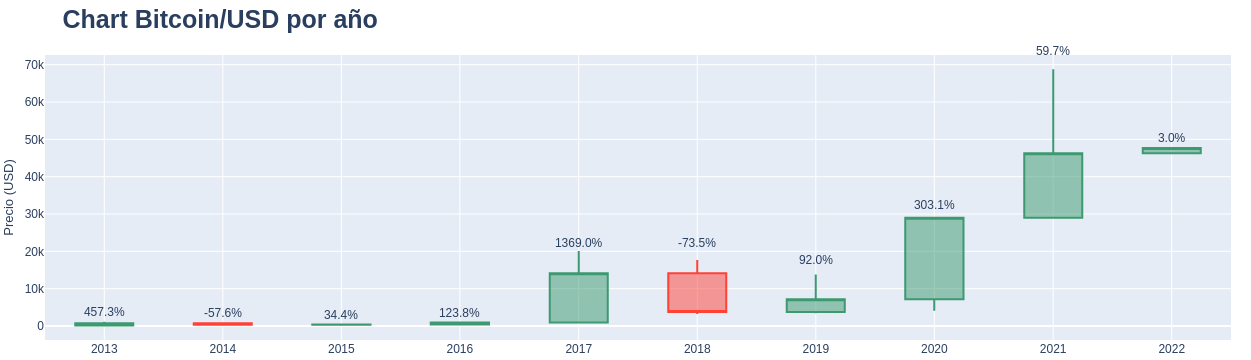

In [57]:
# Se crea una lista de dicts con las anotaciones de % de cambio para el gráfico
# ==============================================================================
annotations_list = []
max_high = df_plot['high'].max()

for year in years:
    
    df_aux = df_plot[df_plot.index == year]
    loc_x = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y = df_aux['high'].values[0]/max_high + 0.05
    text = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Gráfico de velas japonesas anual interactivo
# ==============================================================================
candlestick = go.Candlestick(
                            x = pd.to_datetime(df_plot.index, format='%Y'),
                            open = df_plot.open,
                            close = df_plot.close,
                            low = df_plot.low,
                            high = df_plot.high
                            )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Chart Bitcoin/USD por año</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
    )

fig.show()

### Estacionalidad anual, mensual y semanal

In [99]:
# Se localizan los datos correspondientes para cada mes
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for mes in range(12):
        
        start_date = pd.to_datetime(f'{year}-{mes+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data.index >= start_date) & (data.index < end_date)
        
        if not data.loc[mask, :].empty:
                        
            month_open  = data.loc[mask, 'open'][0]
            month_close = data.loc[mask, 'close'][-1]
            month_low  = data.loc[mask, 'low'].min()
            month_high = data.loc[mask, 'high'].max()
            serie = pd.Series([month_open, month_close, month_low, month_high])
            
            df_aux = pd.DataFrame(serie, columns=[f'{str(mes+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

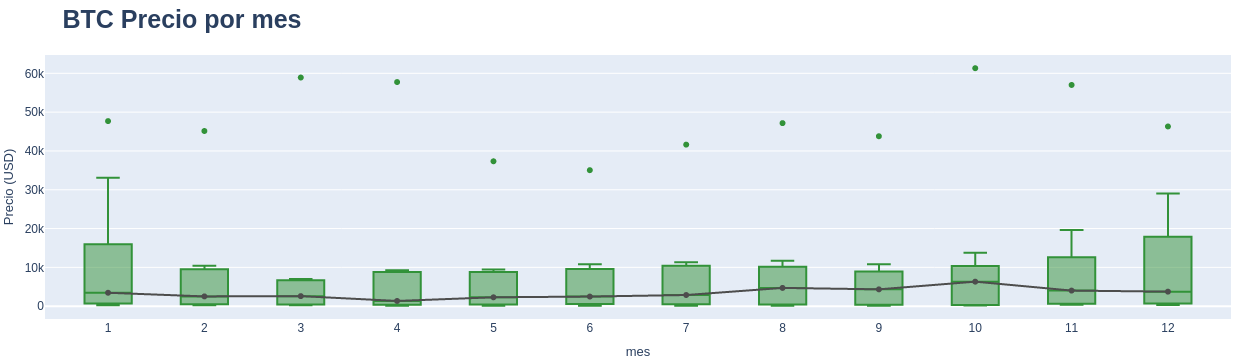

In [100]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
# df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='close', by='mes', ax=ax)
# df_plot.groupby('mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por mes')
# fig.suptitle('');

df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 boxplot de los meses
fig1 = px.box(df_plot.sort_values('mes'), x='mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(df_plot.groupby('mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='mes', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

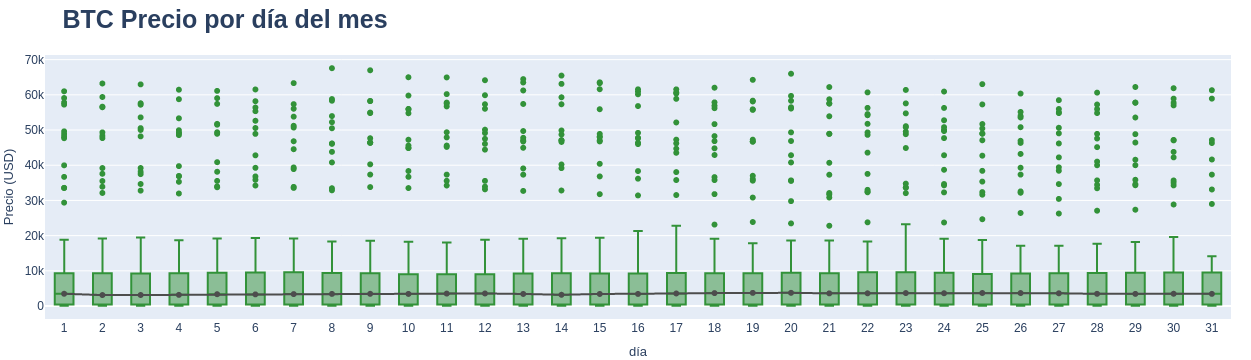

In [41]:
# Gráfico boxplot para estacionalidad mensual
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['dia_mes'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='close', by='dia_mes', ax=ax)
# data.groupby('dia_mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día del mes')
# fig.suptitle('');

data['dia_mes'] = pd.Series(data.index).dt.day.values

# fig 1 boxplot de los meses
fig1 = px.box(data.sort_values('dia_mes'), x='dia_mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(data.groupby('dia_mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día del mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='día', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

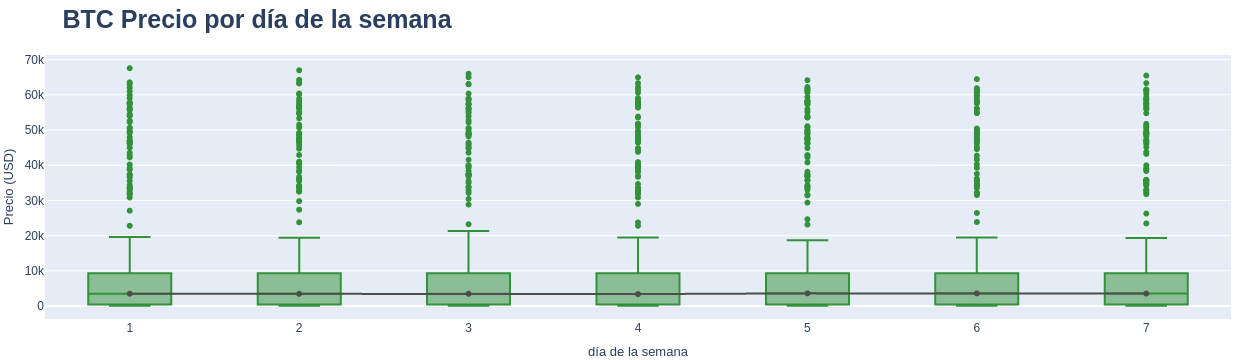

In [101]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['dia_semana'] = data.index.day_of_week + 1
# data.boxplot(column='close', by='dia_semana', ax=ax)
# data.groupby('dia_semana')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día de la semana');

data['dia_semana'] = data.index.day_of_week + 1

# fig 1 boxplot de los meses
fig1 = px.box(data.sort_values('dia_semana'), x='dia_semana', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(data.groupby('dia_semana')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_semana', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día de la semana</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

Por lo general, una serie temporal con capacidad autoregresiva presenta un carácter repetitivo a lo largo del tiempo (tendencia, estacionalidad, factores cíclicos...). Respecto al Bitcoin, se puede apreciar una cierta estacionalidad anual al final y principio del año con variaciones más grandes en el precio. En cambio, no aparece ningún tipo de estacionalidad en los intervalos mensual y semanal, se tienen distribuciones muy similares.

### Gráficos de autocorrelación

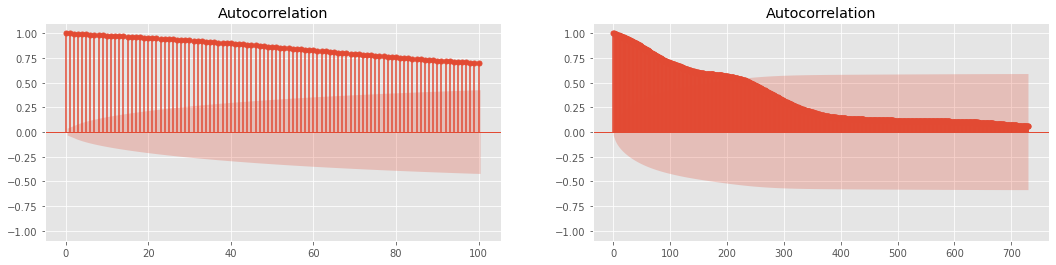

In [23]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

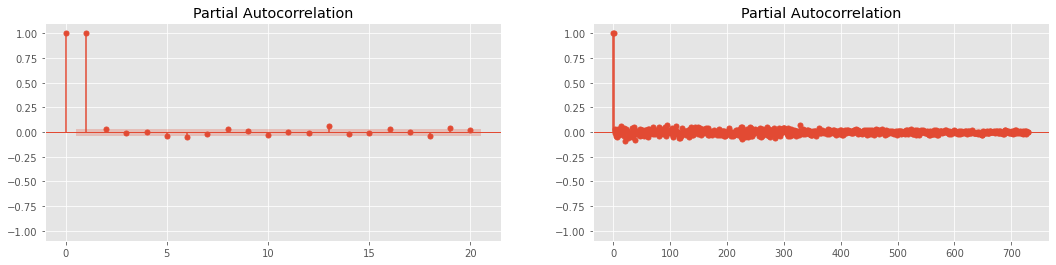

In [24]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

Los gráficos de autocorrelación indican que el *lag* 1 es el único que está correlacionado con el *lag* 0. Los siguientes *lags* no superan el umbral de significancia.

## Forecaster Autorregresivo
<br>

Aunque se dispone de una serie temporal amplia, esta presenta periodos con precios muy diferenciados como se ha podido determinar en la exploración gráfica. Se opta por utilizar solo el último año de datos para estudiar la capacidad autorregresiva del precio del Bitcoin. Se utiliza como modelo base un regresor [**LightGBM**](https://lightgbm.readthedocs.io/en/latest/), una implementación del algoritmo de **Gradient Boosting** desarrollada por Microsoft que suele conseguir excelentes resultados.

Pese a que con los estudios de autocorrelación y autocorrelación parcial ya se tienen indicios de la ausencia de capacidad autorregresiva, una estrategia para comprobar esto con la propia serie temporal es entrenar un modelo varias veces aplicando diferentes configuraciones de *lags* y calcular sus errores mediante [*backtesting*](https://joaquinamatrodrigo.github.io/skforecast/latest/guides/backtesting.html).

*Nota: Al trabajar con modelos basados en árboles de decisión no es extrictamente necesario realizar ningún tipo de preprocesado a los datos (`StandardScaler`, `MinMaxScaler`...). [Ejemplo de forecasting con scikit-learn pipelines](https://joaquinamatrodrigo.github.io/skforecast/0.4.2/guides/sklearn-pipeline.html).*

In [107]:
# Selección fechas train-test
# ==============================================================================
inicio_train = '2020-01-01 00:00:00'
fin_train = '2021-06-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}")

Serie temporal completa : 2013-04-28 00:00:00 --- 2022-01-01 00:00:00
Fechas train            : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00
Fechas test             : 2021-07-01 00:00:00 --- 2022-01-01 00:00:00


Se genera una función para realizar las siguientes acciones:

0. Comprobar si existen variables exogenas que añadir al modelo.

1. Crear el objeto forecaster y entrenarlo desde la fecha `inicio_train` hasta `fin_train`.

2. Realizar un *backtest* sobre las observaciones utilizadas para entrenamiento. Para una mayor explicación visitar: [Predicciones en los datos de entrenamiento](https://joaquinamatrodrigo.github.io/skforecast/0.4.2/guides/backtesting.html).

In [109]:
# Entrenar modelo con diferentes lags
# ==============================================================================
lags = [1, 7, 30, [1, 2, 3, 7, 8, 30, 31]]
metricas_train = []
metricas_test = []

for lag in lags:
    
    # Crear y entrenar forecaster
    forecaster = ForecasterAutoreg(
                    regressor = LGBMRegressor(random_state=123),
                    lags      = lag
                 )
    
    forecaster.fit(y=data.loc[inicio_train:fin_train, 'close'])
    
    # Backtest training data, necesario initial_train_size = None y refit = False
    metrica_train, predicciones_train = backtesting_forecaster(
                                            forecaster = forecaster,
                                            y          = data.loc[inicio_train:fin_train, 'close'],
                                            initial_train_size = None,
                                            steps      = 1,
                                            refit      = False,
                                            metric     = 'mean_squared_error',
                                            verbose    = False
                                        )    
    # Backtest test data, refit = False
    metrica_test, predicciones_test = backtesting_forecaster(
                                         forecaster = forecaster,
                                         y          = data.loc[inicio_train:, 'close'],
                                         initial_train_size = len(data.loc[inicio_train:fin_train, 'close']),
                                         steps      = 1,
                                         refit      = False,
                                         metric     = 'mean_squared_error',
                                         verbose    = False
                                      )
    
    metricas_train.append(float(metrica_train**0.5))
    metricas_test.append(float(metrica_test**0.5))

In [110]:
metricas_train

[1134.3528862961518, 804.2928277679827, 494.64631202831623, 783.383173462896]

In [24]:
# Función crear, entrenar y testear forecaster
# ==============================================================================
def producir_predicciones_forecaster(modelo, lags, variable, exog=None):
    
    # Crear sets variables exogenas si existen
    if exog is None:
        exog_train = None
        exog_test = None
    else:
        exog_train = data.loc[inicio_train:fin_train, exog]
        exog_test = data.loc[inicio_train:, exog]
    
    # Crear y entrenar forecaster
    forecaster = ForecasterAutoreg(
                    regressor = modelo,
                    lags      = lags
                 )

    forecaster.fit(y=data.loc[inicio_train:fin_train, variable],
                   exog=exog_train)

    # Backtest training data, necesario initial_train_size = None y refit = False
    metrica_train, predicciones_train = backtesting_forecaster(
                                            forecaster = forecaster,
                                            y          = data.loc[inicio_train:fin_train, variable],
                                            exog       = exog_train,
                                            initial_train_size = None,
                                            steps      = 1,
                                            refit      = False,
                                            metric     = 'mean_squared_error',
                                            verbose    = False
                                        )    
    # Backtest test data, refit = False
    metrica_test, predicciones_test = backtesting_forecaster(
                                         forecaster = forecaster,
                                         y          = data.loc[inicio_train:, variable],
                                         exog       = exog_test,
                                         initial_train_size = len(data.loc[inicio_train:fin_train, variable]),
                                         steps      = 7,
                                         refit      = False,
                                         metric     = 'mean_squared_error',
                                         verbose    = False
                                      )
    
    return metrica_train, metrica_test, predicciones_train, predicciones_test

,lags,error_train,error_test,Exog
0,1,1134.352886,3804.964664,False
1,7,804.292828,4303.978072,False
2,30,494.646312,4389.836613,False
3,"[1, 2, 3, 7, 8, 30, 31]",783.383173,4267.720363,False


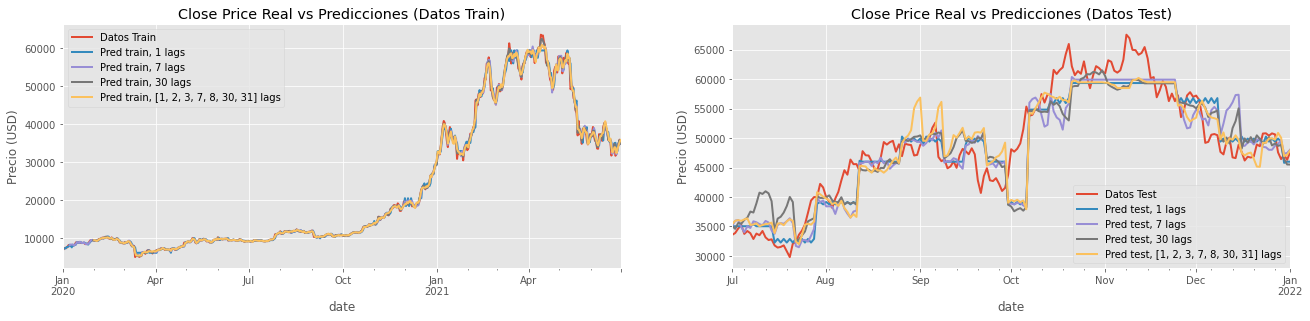

In [56]:
# Gráfico
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 4.5))
axes = axes.flat
data.loc[inicio_train:fin_train, 'close'].plot(ax=axes[0], linewidth=2, label='Datos Train')
data.loc[fin_train:, 'close'].plot(ax=axes[1], linewidth=2, label='Datos Test')

# Entrenar y plot modelo con diferentes lags
# ==============================================================================
lags = [1, 7, 30, [1, 2, 3, 7, 8, 30, 31]]
metricas_train = []
metricas_test = []

for lag in lags:
    
    metrica_train, metrica_test, predicciones_train, \
    predicciones_test = producir_predicciones_forecaster(
                            LGBMRegressor(random_state=123), 
                            lag, 'close'
                            )
    
    metricas_train.append(float(metrica_train**0.5))
    metricas_test.append(float(metrica_test**0.5))
    
    # Plot predicciones_train
    predicciones_train.rename(columns={'pred': f'Pred train, {lag} lags'}, inplace=True)
    predicciones_train.tail(len(data['close'])).plot(linewidth=2, ax=axes[0])
    
    # Plot predicciones_test
    predicciones_test.rename(columns={'pred': f'Pred test, {lag} lags'}, inplace=True)
    predicciones_test.plot(linewidth=2, ax=axes[1])

axes[0].set_title('Close Price Real vs Predicciones (Datos Train)')
axes[1].set_title('Close Price Real vs Predicciones (Datos Test)')
for ax in axes:
    ax.set_ylabel('Precio (USD)')
    ax.legend();
    
df_errores = pd.DataFrame({'lags': lags,
                           'error_train': metricas_train,
                           'error_test': metricas_test,
                           'Exog': False})
display(df_errores)

Representando los datos predichos se observa un alto grado de [*overfitting*](https://es.wikipedia.org/wiki/Sobreajuste) en la partición de entrenamiento provocando que, en los datos de test, el modelo no sea capaz de predecir los movimientos del precio.

Una situación que puede generar [*overfitting*](https://es.wikipedia.org/wiki/Sobreajuste) es el uso de un elevado número de predictores en la creación del modelo. Comparar el bias y la varianza en las predicciones según se va aumentando la complejidad del modelo (número de predictores en este caso) puede ayudar a identificar en que punto del [*Tradeoff* Bias-Varianza](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) se encuentra el modelo.

In [30]:
# Caclular metricas del modelo según aumenta el número de lags
# ==============================================================================
lags = [x+1 for x in range(100)]
metricas_train = []
stds_train = []
metricas_test = []
stds_test = []

for lag in tqdm(lags):
    metrica_train, metrica_test, predicciones_train \
    , predicciones_test = producir_predicciones_forecaster(
                            LGBMRegressor(random_state=123), 
                            lag, "close"
                            )
    
    metricas_train.append(float(metrica_train))
    metricas_test.append(float(metrica_test))
    stds_train.append(predicciones_train.pred.std())
    stds_test.append(predicciones_test.pred.std())

100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


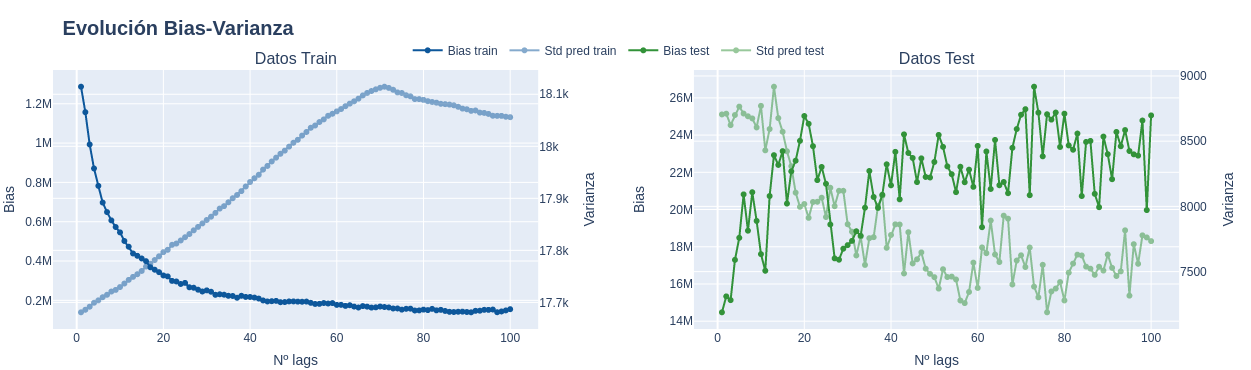

In [31]:
# Gráfico Bias-Varianza
# ==============================================================================
fig = make_subplots(rows=1, cols=2, horizontal_spacing = 0.13,
                    subplot_titles=("Datos Train", "Datos Test"),
                    specs=[[{"secondary_y": True}, {"secondary_y": True}]])

labels = ['Bias train', 'Std pred train', 'Bias test', 'Std pred test']
plots = [metricas_train, stds_train, metricas_test, stds_test]
secondarys = [False, True, False, True]
colores = [palette_btc['azul'], palette_btc['azul'], palette_btc['verde'], palette_btc['verde']]
opacidades = [1, 0.5, 1, 0.5]
cols = [1, 1, 2, 2]

for label, plot, secondary, color, opacidad, col in zip(labels, plots, secondarys, colores, opacidades, cols):
    
    # Se añanden todas las lineas con un ciclo
    fig.add_trace(
        go.Scatter(x=lags, y=plot, name=f'{label}', mode='lines+markers',
                   opacity=opacidad, line=dict(color=color)),
                   secondary_y=secondary, row=1, col=col
        )
    
fig.update_layout(
    width       = 1200,
    height      = 370,
    title       = dict(text='<b>Evolución Bias-Varianza</b>', font=dict(size=20)),
    legend      = dict(orientation="h", yanchor="bottom",
                       y=1.02, xanchor="right", x=0.65),
    margin      = dict(l=0, r=0, t=70, b=40),
)
fig.update_xaxes(title_text='Nº lags')
fig.update_yaxes(title_text='Bias', secondary_y=False)
fig.update_yaxes(title_text='Varianza', secondary_y=True)
fig.show();

Un buen balance entre bias y varianza minimiza el error total del modelo generado o, dicho de otro modo, a la hora de predecir nuevos datos el modelo es capaz de generalizar lo aprendido en las observaciones de entrenamiento. Según aumenta la complejidad del modelo, es de esperar que el bias se reduzca y la varianza aumente ([*Tradeoff* Bias-Varianza](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)).

Aunque en los datos de entrenamiento se puede observar una curva tipo, los **datos de test** (los cuales reflejan cómo de bien generaliza el modelo) muestran una ausencia de aprendizaje del comportamiento pasado, independientemente del número de *lags* utilizado. Además, esto indica que no merece la pena invertir tiempo en la optimización de lags e hiperparámetros.

## Forecaster con variables exógenas
<br>

Además de utilizar predictores autorregresivos generados a partir del pasado de la propia variable respuesta, es posible añadir otras variables exógenas, **cuyo valor a futuro se conoce**, con el fin de mejorar la predicción. Algunos ejemplos típicos son:

+ Festivos (local, nacional...)

+ Mes del año

+ Día de la semana

+ Hora del día

Para este caso, se decide utilizar las variables resultantes del apartado sobre el halving del Bitcoin y, tras el estudio de la estacionalidad, el mes del año.

In [32]:
# Selección fechas train-test
# ==============================================================================
inicio_train = '2020-01-01 00:00:00'
fin_train = '2021-06-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}")

Serie temporal completa : 2013-04-28 00:00:00 --- 2022-01-01 00:00:00
Fechas train            : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00
Fechas test             : 2021-07-01 00:00:00 --- 2022-01-01 00:00:00


Las variables `reward` y `mes`, aunque codificadas como números, son categóricas, por lo que conviene cambiar el tipo con el que están almacenadas.

Dado que estas variables no tienen muchos niveles se recurre a la estrategia de [*One Hot Encoding*](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html#Binarizaci%C3%B3n-de-las-variables-cualitativas) para incorporarlas al modelo.

In [33]:
# Cambio de las variables categóricas a tipo category
# ==============================================================================
data['mes'] = data.index.month
data['mes']   = data['mes'].astype('category')
data['reward'] = data['reward'].astype('category')

# One hot encoding
data = pd.get_dummies(data, columns=['reward', 'mes'])

data.head(2)

,open,close,high,low,change_pct,countdown_halving,dia_mes,dia_semana,reward_6.25,reward_12.5,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006,-0.805614,1168.0,28,7,0,0,...,0,1,0,0,0,0,0,0,0,0
2013-04-29,134.444000,144.539993,147.488007,134.000000,7.509441,1167.0,29,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [34]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding.
# ==============================================================================
variables_exogenas = [column for column in data.columns
                      if column.startswith(('reward', 'mes'))]
variables_exogenas.extend(['countdown_halving'])
print(variables_exogenas)

['reward_6.25', 'reward_12.5', 'reward_25.0', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12', 'countdown_halving']


In [48]:
# Función crear, entrenar y testear forecaster con variables exógenas
# ==============================================================================
def producir_predicciones_forecaster_exog(modelo, lags, variable, exog):
    
    # Crear y entrenar forecaster
    forecaster = ForecasterAutoreg(
                    regressor = modelo,
                    lags      = lags
                 )

    forecaster.fit(y    = data.loc[inicio_train:fin_train, variable],
                   exog = data.loc[inicio_train:fin_train, exog])

    # Backtest training data
    metrica_train, predicciones_train = backtesting_forecaster(
                                            forecaster = forecaster,
                                            y          = data.loc[inicio_train:fin_train, variable],
                                            exog       = data.loc[inicio_train:fin_train, exog],
                                            initial_train_size = None,
                                            steps      = 1,
                                            refit      = False,
                                            metric     = 'mean_squared_error',
                                            verbose    = False
                                        )    
    # Backtest test data, refit = False
    metrica_test, predicciones_test = backtesting_forecaster(
                                         forecaster = forecaster,
                                         y          = data.loc[inicio_train:, variable],
                                         exog       = data.loc[inicio_train:, exog],
                                         initial_train_size = len(data.loc[inicio_train:fin_train, variable]),
                                         steps      = 7,
                                         refit      = False,
                                         metric     = 'mean_squared_error',
                                         verbose    = False
                                      )
    
    return metrica_train, metrica_test, predicciones_train, predicciones_test

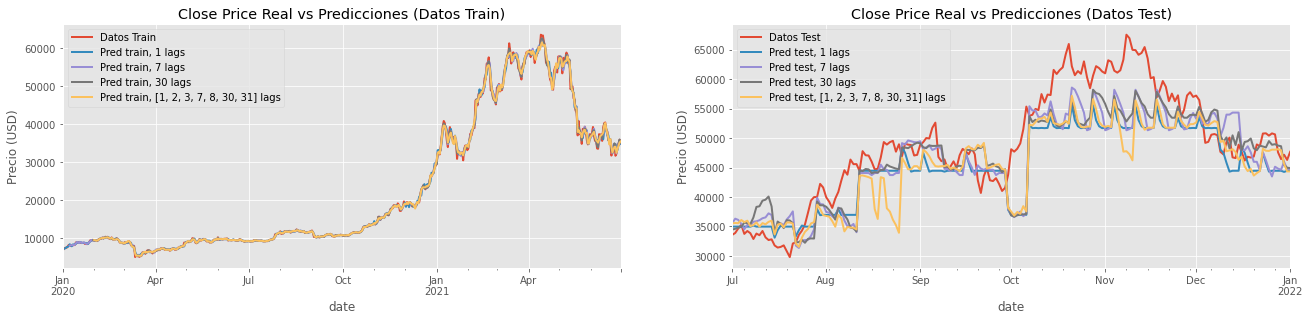

In [57]:
# Gráfico
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 4.5))
axes = axes.flat
data.loc[inicio_train:fin_train, 'close'].plot(ax=axes[0], linewidth=2, label='Datos Train')
data.loc[fin_train:, 'close'].plot(ax=axes[1], linewidth=2, label='Datos Test')

# Entrenar y plot modelo con diferentes lags
# ==============================================================================
lags = [1, 7, 30, [1, 2, 3, 7, 8, 30, 31]]
metricas_train = []
metricas_test = []

for lag in lags:

    metrica_train, metrica_test, predicciones_train, \
    predicciones_test = producir_predicciones_forecaster_exog(
                            LGBMRegressor(random_state=123), 
                            lag, 'close', variables_exogenas
                            )
    
    metricas_train.append(float(metrica_train**0.5))
    metricas_test.append(float(metrica_test**0.5))
    
    # Plot predicciones_train
    predicciones_train.rename(columns={'pred': f'Pred train, {lag} lags'}, inplace=True)
    predicciones_train.tail(len(data['close'])).plot(linewidth=2, ax=axes[0])
    
    # Plot predicciones_test
    predicciones_test.rename(columns={'pred': f'Pred test, {lag} lags'}, inplace=True)
    predicciones_test.plot(linewidth=2, ax=axes[1])

axes[0].set_title('Close Price Real vs Predicciones (Datos Train)')
axes[1].set_title('Close Price Real vs Predicciones (Datos Test)')
for ax in axes:
    ax.set_ylabel('Precio (USD)')
    ax.legend();
    
df_errores = pd.concat([df_errores, pd.DataFrame({'lags': lags, 
                                         'error_train': metricas_train,
                                         'error_test': metricas_test, 
                                         'Exog': True
                                        })
                       ])

In [52]:
# Caclular metricas del modelo según aumenta el número de lags
# ==============================================================================
lags = [x+1 for x in range(100)]
metricas_train = []
stds_train = []
metricas_test = []
stds_test = []

for lag in tqdm(lags):
    metrica_train, metrica_test, predicciones_train \
    , predicciones_test = producir_predicciones_forecaster_exog(
                            LGBMRegressor(random_state=123), 
                            lag, 'close', variables_exogenas)
    
    metricas_train.append(float(metrica_train))
    metricas_test.append(float(metrica_test))
    stds_train.append(predicciones_train.pred.std())
    stds_test.append(predicciones_test.pred.std())

100%|█████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


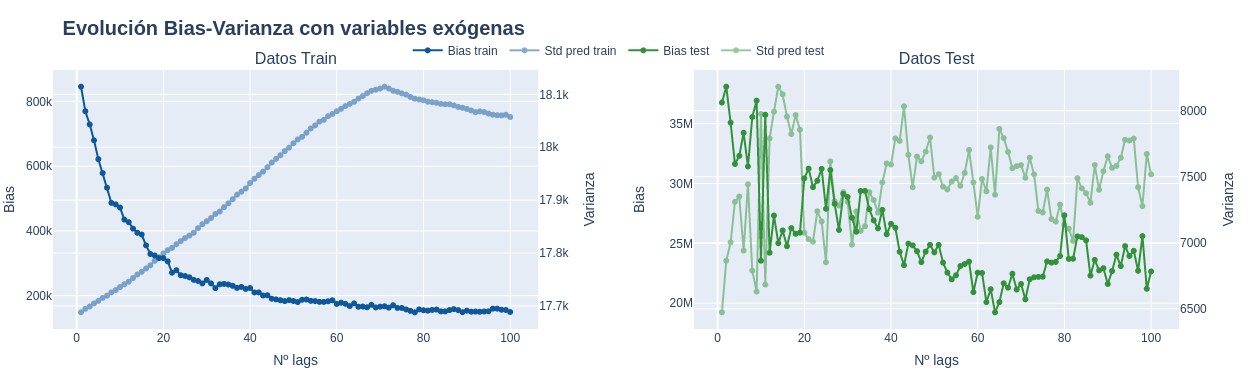

In [54]:
# Gráfico Bias-Varianza
# ==============================================================================
fig = make_subplots(rows=1, cols=2, horizontal_spacing = 0.13,
                    subplot_titles=("Datos Train", "Datos Test"),
                    specs=[[{"secondary_y": True}, {"secondary_y": True}]])

labels = ['Bias train', 'Std pred train', 'Bias test', 'Std pred test']
plots = [metricas_train, stds_train, metricas_test, stds_test]
secondarys = [False, True, False, True]
colores = [palette_btc['azul'], palette_btc['azul'], palette_btc['verde'], palette_btc['verde']]
opacidades = [1, 0.5, 1, 0.5]
cols = [1, 1, 2, 2]

for label, plot, secondary, color, opacidad, col in zip(labels, plots, secondarys, colores, opacidades, cols):
    
    # Se añanden todas las lineas con un ciclo
    fig.add_trace(
        go.Scatter(x=lags, y=plot, name=f'{label}', mode='lines+markers',
                   opacity=opacidad, line=dict(color=color)),
                   secondary_y=secondary, row=1, col=col
        )
    
fig.update_layout(
    width       = 1200,
    height      = 370,
    title       = dict(text='<b>Evolución Bias-Varianza con variables exógenas</b>',
                       font=dict(size=20)),
    legend      = dict(orientation="h", yanchor="bottom",
                       y=1.02, xanchor="right", x=0.65),
    margin      = dict(l=0, r=0, t=70, b=40),
)
fig.update_xaxes(title_text='Nº lags')
fig.update_yaxes(title_text='Bias', secondary_y=False)
fig.update_yaxes(title_text='Varianza', secondary_y=True)
fig.show();

In [60]:
display(df_errores)

,lags,error_train,error_test,Exog
0,1,1134.352886,3804.964664,False
1,7,804.292828,4303.978072,False
2,30,494.646312,4389.836613,False
3,"[1, 2, 3, 7, 8, 30, 31]",783.383173,4267.720363,False
0,1,919.699954,6063.587130,True
1,7,730.516233,5605.933432,True
2,30,498.404216,5373.981987,True
3,"[1, 2, 3, 7, 8, 30, 31]",716.995091,6529.551949,True


En este caso, las variables exógenas seleccionadas no aumentan la capacidad predictiva del modelo.

## Teoría del paseo aleatorio (*Random Walk*)
<br>

Antes de comenzar con este estudio es importante destacar que la evolución de los precios de un activo, en este caso el Bitcoin, se clasifica como un [proceso estocástico](https://es.wikipedia.org/wiki/Proceso_estoc%C3%A1stico). Este se define como la evolución de una variable aleatoria en función de otra que, en el caso de series temporales, es el tiempo. Según la [teoría del paseo aleatorio](https://economipedia.com/definiciones/teoria-paseo-aleatorio.html), los precios de mercado se comportan de manera aleatoria y no dependiente de su serie temporal. De esta manera, la mejor estimación para el valor $t_{n+1}$ es el valor $t_{n}$ más un cambio impredecible. 

Esto se puede comprobar graficamente:

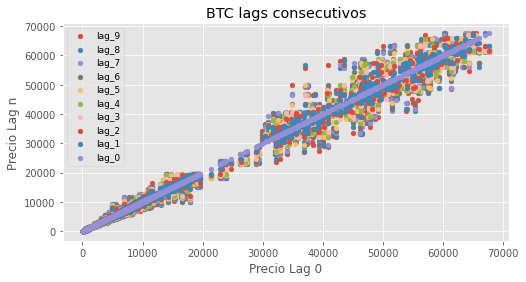

In [14]:
# Gráfico lags consecutivos
# ==============================================================================
df_plot = data[['close']].copy()
lags = 10
for i in range(lags):
    df_plot[f'lag_{i}'] = df_plot.close.shift(i)
    
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(lags)[::-1]:   
    ax.scatter(df_plot['close'], df_plot[f'lag_{i}'], label=f'lag_{i}', s=23)

ax.set(xlabel='Precio Lag 0', ylabel='Precio Lag n',
       title='BTC lags consecutivos')
ax.legend(prop={'size': 9});

Según aumenta la distancia con respecto a la serie inicial (*lag 0*), la diferencia entre los precios, por lo general, es mayor. Esto se comprueba dado que a mayor lag existe más dispersión de los puntos respecto a la recta $x = y$.

Esto refleja la ausencia de carácter autorregresivo en la estimación y evolución de los valores de mercado.

In [143]:
# Simular random walk con datos test
# ==============================================================================
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)
df_rw.loc[fin_train:, :]

y_true = df_rw.loc[fin_train:, 'close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
mean_squared_error(y_true, y_pred)**0.5

1662.8710819912787

**Simular el paseo aleatorio**, el dataset crear precio close -1 shift(close). Resta de las dos columna y es el error de predicción. Lag 0 real, Lag -1 pred. Predicción de cada dia es el anterior

## Conclusión
<br>

+ Como se ha demostrado en este documento, el precio del Bitcoin no tiene capacidad autorregresiva, la mejor estimación para el valor $t_{n+1}$ será el valor $t_{n}$ más un cambio impredecible. La identificación temprana de la ausencia de esta capacidad mediante análisis descriptivo evita invertir tiempo en la selección y ajuste, de hiperparámetros (*tuning*), del modelo.

+ Cuando se dispone de una serie temporal con ausencia de capacidad autorregresiva se deben buscar variables exógenas capaces de ayudar en el problema. Por ejemplo, si se intentase predecir el precio del Bitcoin a corto plazo (horas) podrían emplearse como variables exógenas: el sentimiento del mercado mediante el análisis de tweets, impacto de los denominados *key opinion leaders*, análisis de noticias más relevantes.

+ Utilizar modelos de machine learning en problemas de *forecasting* es muy sencillo gracias a las funcionalidades ofrecidas por [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html).
<br><br>

## Información de sesión

In [144]:
import session_info
session_info.show(html=False)

-----
cryptocmd           0.6.0
lightgbm            3.3.1
matplotlib          3.5.1
numpy               1.22.0
pandas              1.3.5
plotly              5.5.0
scipy               1.7.3
seaborn             0.11.2
session_info        1.0.0
skforecast          0.4.3.dev2
sklearn             1.0.2
statsmodels         0.13.1
tqdm                4.62.3
-----
IPython             7.29.0
jupyter_client      7.1.0
jupyter_core        4.9.1
jupyterlab          3.2.5
notebook            6.4.6
-----
Python 3.8.0 (default, Nov  6 2019, 21:49:08) [GCC 7.3.0]
Linux-5.13.0-30-generic-x86_64-with-glibc2.10
-----
Session information updated at 2022-02-21 14:04


**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
Predicción del precio de Bitcoin con Python, cuando el pasado no se repite by Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at 
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by Javier Escobar Ortiz is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

# Generación Gif

**Gif articulo BTC**

In [54]:
repeat_it = 0

if repeat_it == 1:
    import gif
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('ggplot')
    import pandas as pd
    import datetime
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore')
    
    palette_btc = {'naranja': '#f7931a',
                   'blanco' : '#ffffff',
                   'gris' : '#4d4d4d',
                   'azul' : '#0d579b',
                   'verde' : '#329239'
                  }
    
    # Crear listas con inicio y fin de los cuadrados de train y test
    data.index.name = 'fecha' # Español
    data['Precio'] = data['close'] # Español
    
    steps = len(data)
    step_size = 100 # Tamaño set test
    
    train_start = 0
    train_end = 600 # Tamaño set train
    test_end = train_end + step_size
    lista_train_start = [train_start]
    lista_train_end = [train_end]
    lista_test_end = [test_end]

    for i in range(steps):

        if test_end > steps - step_size:
            train_start += step_size
            train_end += step_size
            test_end = steps-1

            lista_train_start.append(train_start)
            lista_train_end.append(train_end)
            lista_test_end.append(test_end)

            break
        else:
            train_start += step_size
            train_end += step_size
            test_end += step_size

            lista_train_start.append(train_start)
            lista_train_end.append(train_end)
            lista_test_end.append(test_end)
    
    # Ampliar unos meses con df vacío para mejor visualización
    ampliar = 1
    if ampliar == 1:
        
        meses_ampliar = 2 # Seleccionar cuantos meses
        
        last_date = data.index[-1]
        end = data.index[-1] + datetime.timedelta(days=meses_ampliar*30)
        index = pd.date_range(last_date, end=end, freq='D')
        columns = data.columns
        df_plot = pd.DataFrame(index=index, columns=columns)
        df_plot = pd.concat([data, df_plot])
    else:
        df_plot = data.copy()
    
    @gif.frame
    def custom_plot(df_plot, start_train, end_train, end_test):
               
        min_y = df_plot['Precio'].min()
        max_y = df_plot['Precio'].max()
        train = (df_plot.index[start_train], df_plot.index[end_train])
        test = (df_plot.index[end_train], df_plot.index[end_test])  
        
        xlabels = [""] 
        for year in df_plot.index.year.unique():
            xlabels.append(year)

        fig, ax = plt.subplots(figsize=(10, 3.5))
        df_plot['Precio'].plot(ax=ax, color=palette_btc['naranja'])
        ax.fill_between(train, min_y, max_y, facecolor=palette_btc['verde'], alpha=0.4, zorder=0, label='Entrenamiento')
        ax.fill_between(test, min_y, max_y, facecolor=palette_btc['azul'], alpha=0.4, zorder=0, label='Test')
        ax.set_xticklabels(xlabels, rotation=45, ha='center')
        ax.set_ylabel('Precio (USD)')
        ax.set_title('Bitcoin/USD Chart')
        ax.legend()
        ax.grid(alpha=0.6);

        return(ax)
    
    frames = []
    for i in tqdm(range(len(lista_train_start))):
        start_train = lista_train_start[i]
        end_train = lista_train_end[i]
        end_test = lista_test_end[i]
        frame = custom_plot(df_plot, start_train, end_train, end_test)
        frames.append(frame)

    gif.save(frames, './images/btc_train_test.gif', duration=10, unit='s', between='startend')

**GIF backtesting refit True/False**

In [8]:
repeat_it = 1
refit = False
fixed_train_size = False # Solo con refit=True
ampliar = True # Ampliar unos meses con df vacío para mejor visualización
meses_ampliar = 1
train_start = 0
train_end = 96 # Tamaño set train
step_size = 10 # Tamaño set test
duracion_gif = 8 # Segundos


if repeat_it == 1:
    import gif
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('ggplot')
    import pandas as pd
    import datetime
    from tqdm import tqdm
    import warnings
#     warnings.filterwarnings('ignore')
    
    palette_btc = {'naranja': '#f7931a',
                   'blanco' : '#ffffff',
                   'gris' : '#4d4d4d',
                   'azul' : '#0d579b',
                   'verde' : '#329239'
                  }
    
    # Download data
    # ==============================================================================
    url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
    data_gif = pd.read_csv(url, sep=',')

    # Data preprocessing
    # ==============================================================================
    data_gif['date'] = pd.to_datetime(data_gif['fecha'], format='%Y/%m/%d')
    data_gif = data_gif.set_index('date')
    data_gif = data_gif.rename(columns={'x': 'y'})
    data_gif = data_gif.asfreq('MS')
    data_gif = data_gif['y']
    data_gif = data_gif.sort_index()

    steps = len(data_gif)

    test_start = train_end
    test_end = train_end + step_size
    lista_train_start = [train_start]
    lista_train_end = [train_end]
    lista_test_start = [test_start]
    lista_test_end = [test_end]

    for i in range(steps):

        if test_end > steps - step_size:
            
            if refit:
                if fixed_train_size:
                    train_start += step_size
                train_end += step_size
                test_start += step_size
                test_end = steps-1
            else:
                test_start += step_size
                test_end = steps-1
            
            lista_train_start.append(train_start)
            lista_train_end.append(train_end)
            lista_test_start.append(test_start)
            lista_test_end.append(test_end)

            break
        else:
            if refit:
                if fixed_train_size:
                    train_start += step_size
                train_end += step_size
                test_start += step_size
                test_end += step_size
            else:
                test_start += step_size
                test_end += step_size
                
            lista_train_start.append(train_start)
            lista_train_end.append(train_end)
            lista_test_start.append(test_start)
            lista_test_end.append(test_end)
        
    #  Ampliar unos meses con df vacío para mejor visualización
    if ampliar:
        last_date = data_gif.index[-1]
        end = data_gif.index[-1] + datetime.timedelta(days=meses_ampliar*30)
        index = pd.date_range(last_date, end=end, freq='D')
        df_plot = pd.DataFrame(index=index)
        df_plot = pd.concat([data_gif, df_plot])
    else:
        df_plot = data_gif.copy()
    
    df_plot['y'] = df_plot[0]
    
    @gif.frame
    def custom_plot(df_plot, start_train, end_train, start_test, end_test):
               
        min_y = df_plot['y'].min()
        max_y = df_plot['y'].max()
        train = (df_plot.index[start_train], df_plot.index[end_train])
        test = (df_plot.index[start_test], df_plot.index[end_test])  
        
        xlabels = [""] 
        for year in df_plot.index.year.unique():
            xlabels.append(year)
        
        # Plot
        # ==============================================================================
        fig, ax=plt.subplots(figsize=(9, 4), facecolor='white')
        df_plot['y'].plot(ax=ax)
        ax.fill_between(train, min_y, max_y, facecolor=palette_btc['verde'], alpha=0.4, zorder=0, label='Train')
        ax.fill_between(test, min_y, max_y, facecolor=palette_btc['azul'], alpha=0.4, zorder=0, label='Test')
        ax.set_xticklabels(xlabels, rotation=45, ha='center')
        ax.legend()
        if refit:
            if fixed_train_size:
                ax.set_title('Timeseries backtesting with refit fixed train size')
            else:
                ax.set_title('Timeseries backtesting with refit')
        else:
            ax.set_title('Timeseries backtesting without refit')
            
        return(ax)
    
    frames = []
    for i in tqdm(range(len(lista_train_start))):
        start_train = lista_train_start[i]
        end_train = lista_train_end[i]
        start_test = lista_test_start[i]
        end_test = lista_test_end[i]
        frame = custom_plot(df_plot, start_train, end_train, start_test, end_test)
        frames.append(frame)
    
    
    if refit:
        if fixed_train_size:
            gif.save(frames, './images/backtesting_refit_fixed_train_size.gif', duration=duracion_gif, unit='s', between='startend')
        else:
            gif.save(frames, './images/backtesting_refit.gif', duration=duracion_gif, unit='s', between='startend')
    else:
        gif.save(frames, './images/backtesting_no_refit.gif', duration=duracion_gif, unit='s', between='startend')

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.06it/s]
